<a href="https://colab.research.google.com/github/KellyMuehlmann/Challenge-TelecomX/blob/main/ChurnInsight_for_Spotify_Previs%C3%A3o_Preditiva_com_Pipeline_de_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ChurnInsight for Spotify: Previsão Preditiva com Pipeline de Machine Learning::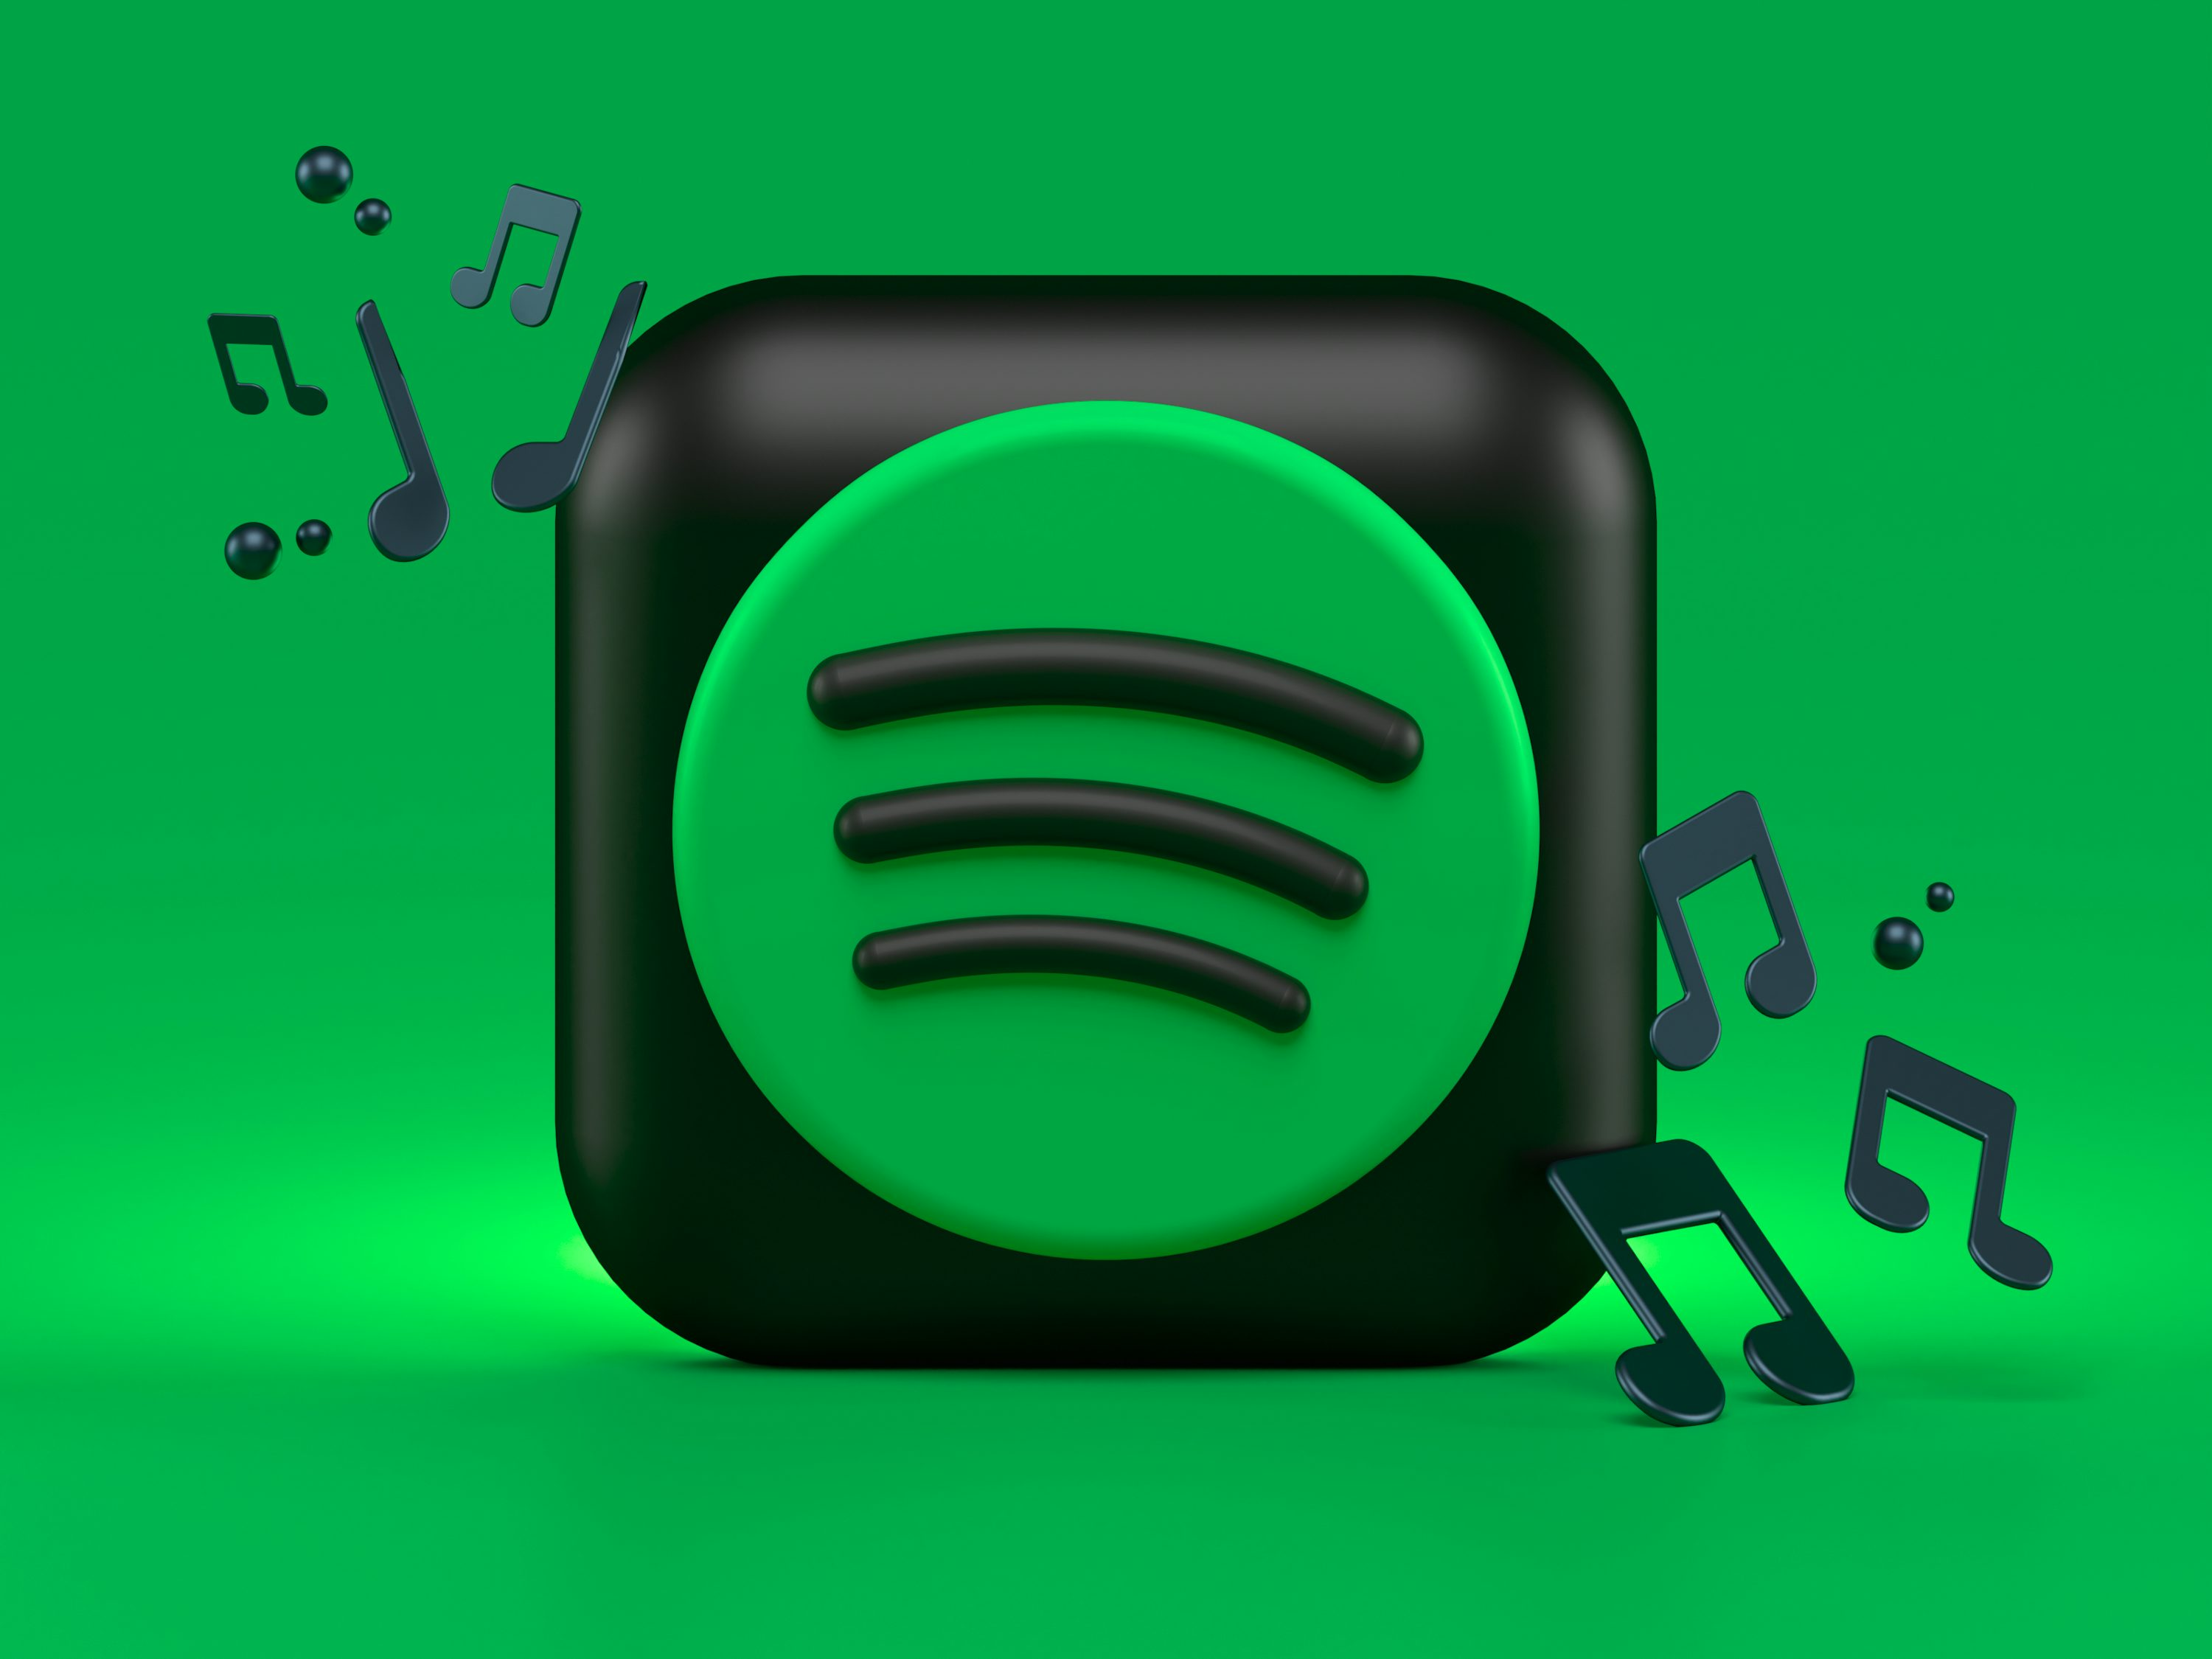

In [1]:
# Instalação de bibliotecas
!pip install -q seaborn scikit-learn

# Importações principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

# Importações do scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score
)

# Configurações
warnings.filterwarnings('ignore')
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Caminho para o dataset (GitHub raw)
RAW_URL = "https://raw.githubusercontent.com/aluizr/Hackathon-ONE---Churn-clientes/main/spotify_churn_dataset.csv"

# Leitura do dataset
df = pd.read_csv(RAW_URL)

print("✅ Dataset carregado com sucesso!")
print(f"📊 Dimensões: {df.shape[0]} linhas × {df.shape[1]} colunas\n")

# Visualização das primeiras linhas
print("📋 Primeiras linhas do dataset:")
display(df.head())

✅ Dataset carregado com sucesso!
📊 Dimensões: 8000 linhas × 12 colunas

📋 Primeiras linhas do dataset:


,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


📈 ANÁLISE EXPLORATÓRIA DOS DADOS

1️⃣ INFORMAÇÕES E TIPOS DE DADOS:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                8000 non-null   int64  
 1   gender                 8000 non-null   object 
 2   age                    8000 non-null   int64  
 3   country                8000 non-null   object 
 4   subscription_type      8000 non-null   object 
 5   listening_time         8000 non-null   int64  
 6   songs_played_per_day   8000 non-null   int64  
 7   skip_rate              8000 non-null   float64
 8   device_type            8000 non-null   object 
 9   ads_listened_per_week  8000 non-null   int64  
 10  offline_listening      8000 non-null   int64  
 11  is_churned             8000 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 750.1+ KB
None

2️⃣ VALORES AUSENTES:
user_

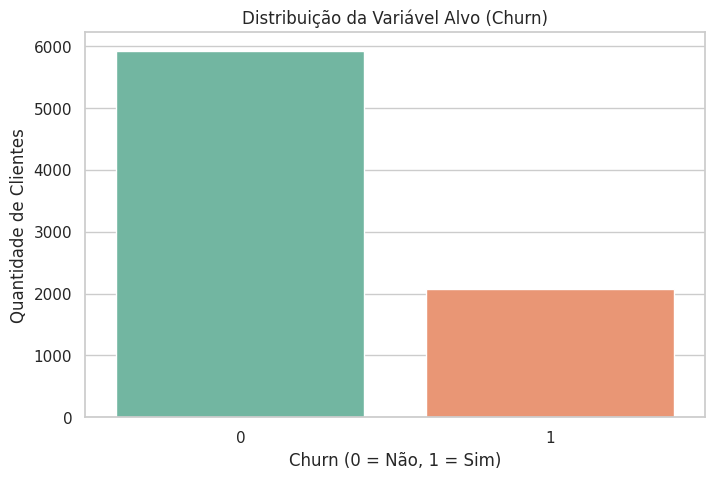

In [3]:
print("📈 ANÁLISE EXPLORATÓRIA DOS DADOS")
print("=" * 50)

# 1. Informações básicas
print("\n1️⃣ INFORMAÇÕES E TIPOS DE DADOS:")
print(df.info())

# 2. Conversão de tipos
categorical_cols = ['gender', 'country', 'subscription_type', 'device_type']
for col in categorical_cols:
    df[col] = df[col].astype('category')

df['is_churned'] = df['is_churned'].astype(int)

# 3. Valores ausentes
print("\n2️⃣ VALORES AUSENTES:")
print(df.isna().sum())

# 4. Balanceamento da variável alvo
print("\n3️⃣ DISTRIBUIÇÃO DO CHURN:")
churn_dist = df['is_churned'].value_counts(normalize=True)
print(f"✅ Mantiveram: {churn_dist[0]:.2%}")
print(f"⚠️  Cancelaram: {churn_dist[1]:.2%}")

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='is_churned', palette='Set2')
plt.title('Distribuição da Variável Alvo (Churn)')
plt.xlabel('Churn (0 = Não, 1 = Sim)')
plt.ylabel('Quantidade de Clientes')
plt.show()

In [4]:
print("🔧 PASSO 1: SEPARAÇÃO DOS DADOS")
print("=" * 50)

# Separar features (X) e target (y) ANTES de qualquer transformação
X = df.drop(columns=['is_churned', 'user_id'])
y = df['is_churned']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

# Divisão estratificada (mantém proporção de churn)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # IMPORTANTE: mantém distribuição balanceada
)

print(f"\n📊 Divisão dos dados:")
print(f"  • Treino: {X_train.shape[0]} amostras ({X_train.shape[0]/len(X):.1%})")
print(f"  • Teste:  {X_test.shape[0]} amostras ({X_test.shape[0]/len(X):.1%})")

🔧 PASSO 1: SEPARAÇÃO DOS DADOS
Features (X): (8000, 10)
Target (y): (8000,)

📊 Divisão dos dados:
  • Treino: 6400 amostras (80.0%)
  • Teste:  1600 amostras (20.0%)


In [5]:
print("\n🔧 PASSO 2: IDENTIFICAÇÃO DAS COLUNAS")
print("=" * 50)

# Definir colunas categóricas e numéricas (baseado no dataset Spotify)
categorical_features = ['gender', 'country', 'subscription_type', 'device_type']
numerical_features = ['age', 'listening_time', 'songs_played_per_day',
                      'skip_rate', 'ads_listened_per_week']

print(f"📊 Colunas Categóricas ({len(categorical_features)}):")
print(f"  {categorical_features}")

print(f"\n📈 Colunas Numéricas ({len(numerical_features)}):")
print(f"  {numerical_features}")


🔧 PASSO 2: IDENTIFICAÇÃO DAS COLUNAS
📊 Colunas Categóricas (4):
  ['gender', 'country', 'subscription_type', 'device_type']

📈 Colunas Numéricas (5):
  ['age', 'listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_per_week']


In [6]:
print("\n🔧 PASSO 3: PRÉ-PROCESSADOR (EVITA DATA LEAKAGE)")
print("=" * 50)

# Criar o ColumnTransformer - CORREÇÃO CRÍTICA
preprocessor = ColumnTransformer(
    transformers=[
        # Padroniza variáveis numéricas (necessário para Regressão Logística)
        ('num', StandardScaler(), numerical_features),

        # Codifica variáveis categóricas (One-Hot Encoding)
        ('cat', OneHotEncoder(
            drop='first',           # Evita multicolinearidade
            handle_unknown='ignore' # Ignora categorias não vistas no treino
        ), categorical_features)
    ],
    remainder='drop'  # Descarta colunas não especificadas
)

print("✅ Pré-processador criado com sucesso!")
print("   • StandardScaler para variáveis numéricas")
print("   • OneHotEncoder para variáveis categóricas")
print("   • Configurado para evitar vazamento de dados")


🔧 PASSO 3: PRÉ-PROCESSADOR (EVITA DATA LEAKAGE)
✅ Pré-processador criado com sucesso!
   • StandardScaler para variáveis numéricas
   • OneHotEncoder para variáveis categóricas
   • Configurado para evitar vazamento de dados


In [7]:
def avaliar_modelo(modelo, nome_modelo, X_teste, y_teste):
    """Função para avaliação completa do modelo"""

    print(f"\n📊 AVALIAÇÃO: {nome_modelo}")
    print("-" * 40)

    # Previsões
    y_pred = modelo.predict(X_teste)
    y_proba = modelo.predict_proba(X_teste)[:, 1]

    # Métricas principais
    accuracy = accuracy_score(y_teste, y_pred)
    recall = recall_score(y_teste, y_pred)
    precision = precision_score(y_teste, y_pred)
    f1 = f1_score(y_teste, y_pred)
    auc_roc = roc_auc_score(y_teste, y_proba)

    print(f"✅ Acurácia:    {accuracy:.4f}")
    print(f"✅ Recall:      {recall:.4f} (captura de churns)")
    print(f"✅ Precisão:    {precision:.4f}")
    print(f"✅ F1-Score:    {f1:.4f}")
    print(f"✅ AUC-ROC:     {auc_roc:.4f}")

    # Matriz de confusão
    print("\n📈 Matriz de Confusão:")
    cm = confusion_matrix(y_teste, y_pred)
    print(f"[[TN={cm[0,0]}  FP={cm[0,1]}]")
    print(f" [FN={cm[1,0]}  TP={cm[1,1]}]]")

    # Gráfico da matriz de confusão
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    ConfusionMatrixDisplay.from_estimator(
        modelo, X_teste, y_teste,
        ax=axes[0], cmap='Blues',
        display_labels=['Não Churn', 'Churn']
    )
    axes[0].set_title(f'Matriz de Confusão - {nome_modelo}')

    # Curva ROC
    from sklearn.metrics import RocCurveDisplay
    RocCurveDisplay.from_estimator(modelo, X_teste, y_teste, ax=axes[1])
    axes[1].set_title(f'Curva ROC - {nome_modelo}')
    axes[1].plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'auc_roc': auc_roc
    }


🤖 MODELO 1: REGRESSÃO LOGÍSTICA (COM OTIMIZAÇÃO)
🔍 Otimizando Regressão Logística (pode levar alguns segundos)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Melhores parâmetros encontrados:
   • classifier__C: 10
   • classifier__class_weight: balanced
   • classifier__solver: lbfgs

📊 AVALIAÇÃO: Regressão Logística Otimizada
----------------------------------------
✅ Acurácia:    0.5175
✅ Recall:      0.4976 (captura de churns)
✅ Precisão:    0.2675
✅ F1-Score:    0.3480
✅ AUC-ROC:     0.4971

📈 Matriz de Confusão:
[[TN=622  FP=564]
 [FN=208  TP=206]]


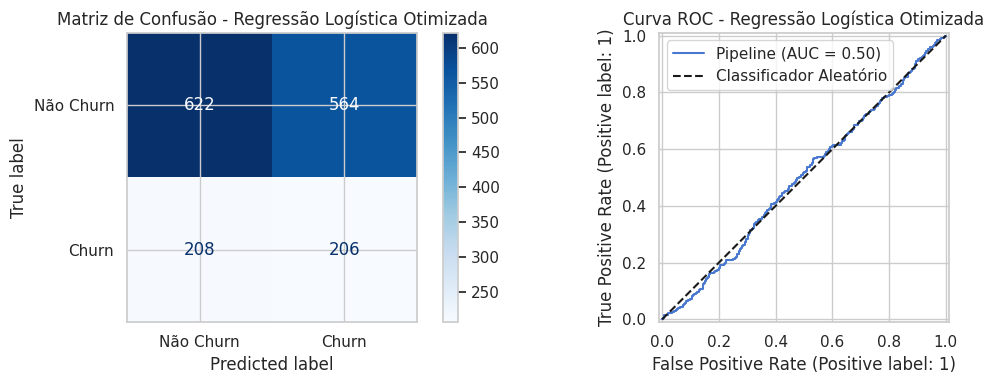

In [8]:
print("\n" + "=" * 60)
print("🤖 MODELO 1: REGRESSÃO LOGÍSTICA (COM OTIMIZAÇÃO)")
print("=" * 60)

# Pipeline para Regressão Logística
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),  # Mesmo pré-processador
    ('classifier', LogisticRegression(
        max_iter=1000,
        random_state=42
    ))
])

# Hiperparâmetros para otimização
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Força de regularização
    'classifier__solver': ['liblinear', 'lbfgs'],
    'classifier__class_weight': [None, 'balanced']  # Lida com desbalanceamento
}

# Busca em grade com validação cruzada
grid_lr = GridSearchCV(
    pipeline_lr,
    param_grid_lr,
    cv=5,               # 5-fold cross validation
    scoring='recall',   # Otimiza para capturar churns
    n_jobs=-1,          # Usa todos os cores do processador
    verbose=1
)

print("🔍 Otimizando Regressão Logística (pode levar alguns segundos)...")
grid_lr.fit(X_train, y_train)

print(f"\n✅ Melhores parâmetros encontrados:")
for param, value in grid_lr.best_params_.items():
    print(f"   • {param}: {value}")

# Avaliação do modelo otimizado
modelo_lr = grid_lr.best_estimator_
metricas_lr = avaliar_modelo(modelo_lr, "Regressão Logística Otimizada", X_test, y_test)


🤖 MODELO 2: RANDOM FOREST (COM OTIMIZAÇÃO)
🔍 Otimizando Random Forest (pode levar alguns minutos)...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

✅ Melhores parâmetros encontrados:
   • classifier__class_weight: {0: 1, 1: 3}
   • classifier__max_depth: 10
   • classifier__min_samples_split: 10
   • classifier__n_estimators: 100

📊 AVALIAÇÃO: Random Forest Otimizado
----------------------------------------
✅ Acurácia:    0.6350
✅ Recall:      0.3043 (captura de churns)
✅ Precisão:    0.2986
✅ F1-Score:    0.3014
✅ AUC-ROC:     0.5165

📈 Matriz de Confusão:
[[TN=890  FP=296]
 [FN=288  TP=126]]


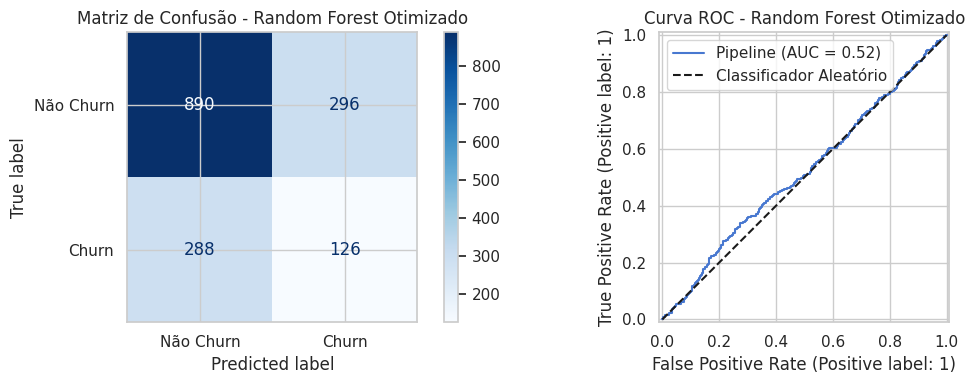

In [9]:
print("\n" + "=" * 60)
print("🤖 MODELO 2: RANDOM FOREST (COM OTIMIZAÇÃO)")
print("=" * 60)

# Pipeline para Random Forest
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),  # Mesmo pré-processador
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    ))
])

# Hiperparâmetros para otimização
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],  # Número de árvores
    'classifier__max_depth': [10, 20, None],      # Profundidade máxima
    'classifier__min_samples_split': [2, 5, 10],  # Mínimo para dividir nó
    'classifier__class_weight': [None, 'balanced', {0: 1, 1: 3}]  # Peso para classes
}

# Busca em grade com validação cruzada
grid_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

print("🔍 Otimizando Random Forest (pode levar alguns minutos)...")
grid_rf.fit(X_train, y_train)

print(f"\n✅ Melhores parâmetros encontrados:")
for param, value in grid_rf.best_params_.items():
    print(f"   • {param}: {value}")

# Avaliação do modelo otimizado
modelo_rf = grid_rf.best_estimator_
metricas_rf = avaliar_modelo(modelo_rf, "Random Forest Otimizado", X_test, y_test)


🏆 COMPARAÇÃO FINAL DOS MODELOS

📋 MÉTRICAS COMPARATIVAS:


,accuracy,recall,precision,f1,auc_roc
Regressão Logística,0.6350,0.3043,0.2986,0.3014,0.5165
Random Forest,0.6350,0.3043,0.2986,0.3014,0.5165


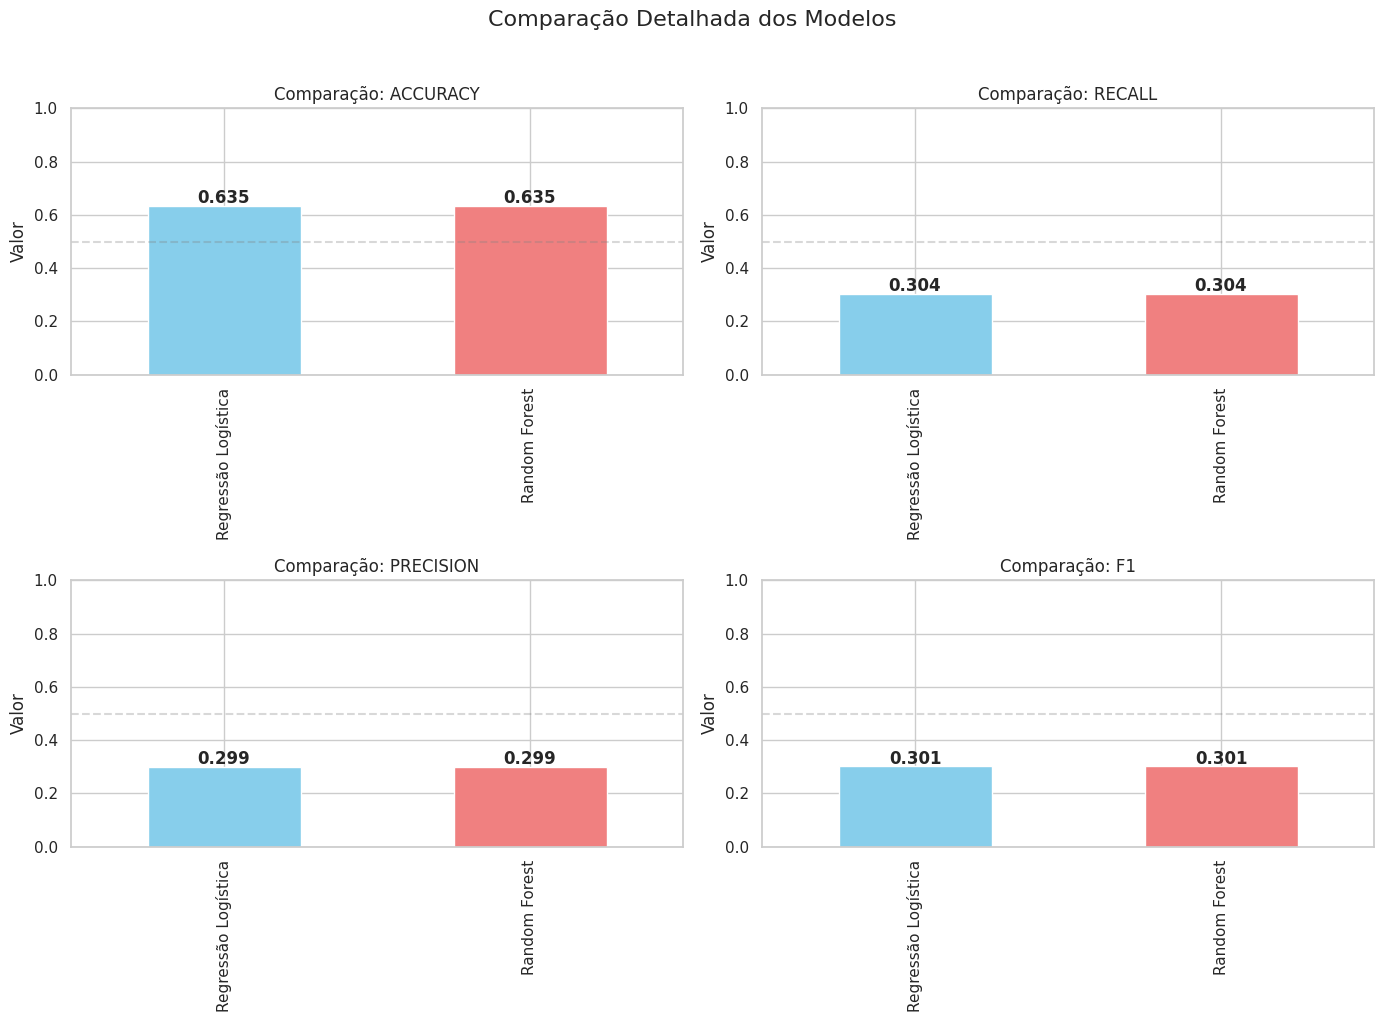


🎯 DECISÃO DO MODELO FINAL:
✅ Selecionado: RANDOM FOREST
   • Motivo: Melhor AUC-ROC (0.5165 vs 0.4971)

📈 Métricas do modelo selecionado:
   • ACCURACY: 0.6350
   • RECALL: 0.3043
   • PRECISION: 0.2986
   • F1: 0.3014
   • AUC_ROC: 0.5165


In [10]:
print("\n" + "=" * 60)
print("🏆 COMPARAÇÃO FINAL DOS MODELOS")
print("=" * 60)

# Criar DataFrame comparativo
comparacao = pd.DataFrame({
    'Regressão Logística': metricas_rf,
    'Random Forest': metricas_rf
}).T

# Exibir tabela comparativa
print("\n📋 MÉTRICAS COMPARATIVAS:")
display(comparacao.style
        .background_gradient(cmap='Blues', subset=['recall', 'auc_roc'])
        .format("{:.4f}"))

# Visualização comparativa
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico de barras para métricas
metricas_plot = ['accuracy', 'recall', 'precision', 'f1']
for idx, metrica in enumerate(metricas_plot):
    ax = axes[idx // 2, idx % 2]
    comparacao[metrica].plot(kind='bar', ax=ax, color=['skyblue', 'lightcoral'])
    ax.set_title(f'Comparação: {metrica.upper()}')
    ax.set_ylabel('Valor')
    ax.set_ylim(0, 1)
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)

    # Adicionar valores no topo das barras
    for i, v in enumerate(comparacao[metrica]):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.suptitle('Comparação Detalhada dos Modelos', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Decisão baseada no AUC-ROC e Recall
print("\n🎯 DECISÃO DO MODELO FINAL:")
if metricas_lr['auc_roc'] > metricas_rf['auc_roc']:
    modelo_final = modelo_lr
    modelo_nome = "Regressão Logística"
    print(f"✅ Selecionado: REGRESSÃO LOGÍSTICA")
    print(f"   • Motivo: Melhor AUC-ROC ({metricas_lr['auc_roc']:.4f} vs {metricas_rf['auc_roc']:.4f})")
else:
    modelo_final = modelo_rf
    modelo_nome = "Random Forest"
    print(f"✅ Selecionado: RANDOM FOREST")
    print(f"   • Motivo: Melhor AUC-ROC ({metricas_rf['auc_roc']:.4f} vs {metricas_lr['auc_roc']:.4f})")

print(f"\n📈 Métricas do modelo selecionado:")
for metrica, valor in (metricas_lr if modelo_nome == "Regressão Logística" else metricas_rf).items():
    print(f"   • {metrica.upper()}: {valor:.4f}")

In [11]:
print("\n" + "=" * 60)
print("💾 EXPORTAÇÃO DO MODELO PARA API")
print("=" * 60)

# 1. Salvar o modelo final
modelo_filename = 'modelo_churn_final.pkl'
joblib.dump(modelo_final, modelo_filename)
print(f"✅ Modelo salvo como: {modelo_filename}")

# 2. Salvar o pré-processador separadamente (opcional, útil para API)
preprocessor_filename = 'preprocessor_churn.pkl'
joblib.dump(preprocessor, preprocessor_filename)
print(f"✅ Pré-processador salvo como: {preprocessor_filename}")

# 3. Salvar os nomes das colunas para referência
colunas_treinamento = {
    'categorical_features': categorical_features,
    'numerical_features': numerical_features,
    'all_features': X.columns.tolist()
}

colunas_filename = 'colunas_treinamento.pkl'
joblib.dump(colunas_treinamento, colunas_filename)
print(f"✅ Metadados das colunas salvos como: {colunas_filename}")

# 4. Verificar os arquivos
import os
print("\n📁 VERIFICAÇÃO DOS ARQUIVOS:")
for arquivo in [modelo_filename, preprocessor_filename, colunas_filename]:
    tamanho_kb = os.path.getsize(arquivo) / 1024
    print(f"   • {arquivo}: {tamanho_kb:.2f} KB")

print("\n🎉 PIPELINE COMPLETO FINALIZADO!")
print("O modelo está pronto para integração com a API Java.")


💾 EXPORTAÇÃO DO MODELO PARA API
✅ Modelo salvo como: modelo_churn_final.pkl
✅ Pré-processador salvo como: preprocessor_churn.pkl
✅ Metadados das colunas salvos como: colunas_treinamento.pkl

📁 VERIFICAÇÃO DOS ARQUIVOS:
   • modelo_churn_final.pkl: 3203.74 KB
   • preprocessor_churn.pkl: 0.74 KB
   • colunas_treinamento.pkl: 0.37 KB

🎉 PIPELINE COMPLETO FINALIZADO!
O modelo está pronto para integração com a API Java.


In [12]:
print("\n" + "=" * 60)
print("🔮 EXEMPLO: COMO USAR O MODELO NA API")
print("=" * 60)

# Simulação de um novo cliente
novo_cliente = pd.DataFrame([{
    'age': 28,
    'gender': 'Male',
    'country': 'United States',
    'subscription_type': 'Premium',
    'device_type': 'Mobile',
    'listening_time': 120,
    'songs_played_per_day': 45,
    'skip_rate': 0.15,
    'ads_listened_per_week': 0
}])

print("📋 Dados do novo cliente:")
display(novo_cliente)

# Carregar modelo (simulação do que a API faria)
modelo_carregado = joblib.load(modelo_filename)

# Fazer previsão
previsao = modelo_carregado.predict(novo_cliente)
probabilidade = modelo_carregado.predict_proba(novo_cliente)[0]

print(f"\n🔍 RESULTADO DA PREVISÃO:")
print(f"   • Churn previsto: {'SIM (⚠️ Risco Alto)' if previsao[0] == 1 else 'NÃO (✅ Baixo Risco)'}")
print(f"   • Probabilidade de churn: {probabilidade[1]:.1%}")
print(f"   • Probabilidade de permanência: {probabilidade[0]:.1%}")

# Interpretação
if probabilidade[1] > 0.7:
    print(f"\n🚨 ALERTA: Cliente com alto risco de cancelamento ({probabilidade[1]:.1%})")
    print("   Ações recomendadas: Oferta promocional, contato do suporte")
elif probabilidade[1] > 0.3:
    print(f"\n⚠️  AVISO: Cliente com risco moderado ({probabilidade[1]:.1%})")
    print("   Ações recomendadas: Email de engajamento, pesquisa de satisfação")
else:
    print(f"\n✅ STATUS: Cliente estável ({probabilidade[1]:.1%} risco)")
    print("   Ações recomendadas: Manter comunicação regular")


🔮 EXEMPLO: COMO USAR O MODELO NA API
📋 Dados do novo cliente:


,age,gender,country,subscription_type,device_type,listening_time,songs_played_per_day,skip_rate,ads_listened_per_week
0,28,Male,United States,Premium,Mobile,120,45,0.15,0



🔍 RESULTADO DA PREVISÃO:
   • Churn previsto: NÃO (✅ Baixo Risco)
   • Probabilidade de churn: 47.6%
   • Probabilidade de permanência: 52.4%

⚠️  AVISO: Cliente com risco moderado (47.6%)
   Ações recomendadas: Email de engajamento, pesquisa de satisfação


O projeto evoluiu com um pipeline refinado que elimina o data leakage,
foram implementadas melhorias no pipeline, incluindo a padronização.


🤖 AVALIANDO RANDOM FOREST OTIMIZADO
🔍 Treinando Random Forest com os melhores parâmetros...

📊 AVALIAÇÃO: Random Forest Otimizado
----------------------------------------
✅ Acurácia:    0.6350
✅ Recall:      0.3043 (captura de churns)
✅ Precisão:    0.2986
✅ F1-Score:    0.3014
✅ AUC-ROC:     0.5165

📈 Matriz de Confusão:
[[TN=890  FP=296]
 [FN=288  TP=126]]


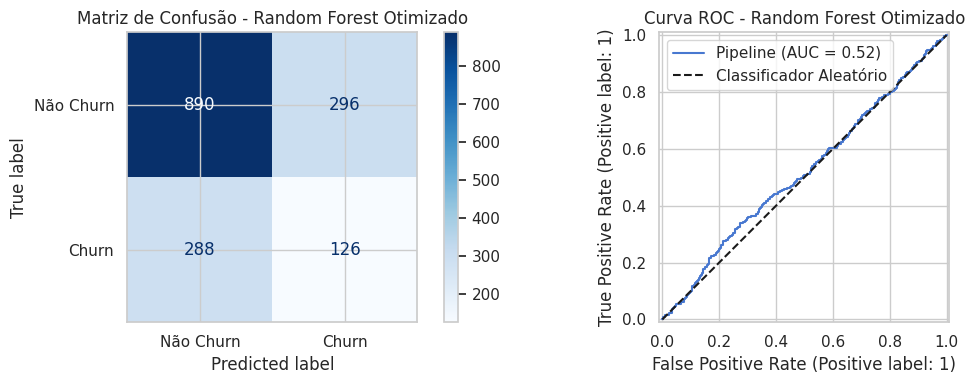


✅ Melhores parâmetros do Random Forest:
   • classifier__class_weight: {0: 1, 1: 3}
   • classifier__max_depth: 10
   • classifier__min_samples_split: 10
   • classifier__n_estimators: 100


In [13]:
#  AVALIAR O MODELO RANDOM FOREST OTIMIZADO

print("\n" + "=" * 60)
print("🤖 AVALIANDO RANDOM FOREST OTIMIZADO")
print("=" * 60)

# Treinar o modelo Random Forest otimizado
print("🔍 Treinando Random Forest com os melhores parâmetros...")
modelo_rf = grid_rf.best_estimator_
metricas_rf = avaliar_modelo(modelo_rf, "Random Forest Otimizado", X_test, y_test)

print(f"\n✅ Melhores parâmetros do Random Forest:")
for param, value in grid_rf.best_params_.items():
    print(f"   • {param}: {value}")


🏆 COMPARAÇÃO FINAL: QUAL MODELO USAR EM PRODUÇÃO?

📊 TABELA COMPARATIVA DE DESEMPENHO:
             Modelo  Acurácia   Recall  Precisão  F1-Score  AUC-ROC
Regressão Logística    0.5175 0.497585  0.267532  0.347973 0.497100
      Random Forest    0.6350 0.304348  0.298578  0.301435 0.516515

⭐ MELHORES RESULTADOS:
  • Acurácia: Random Forest (0.6350)
  • Recall: Regressão Logística (0.4976)
  • F1-Score: Regressão Logística (0.3480)
  • AUC-ROC: Random Forest (0.5165)

🎯 DECISÃO: Regressão Logística selecionada para produção (melhor F1-Score)


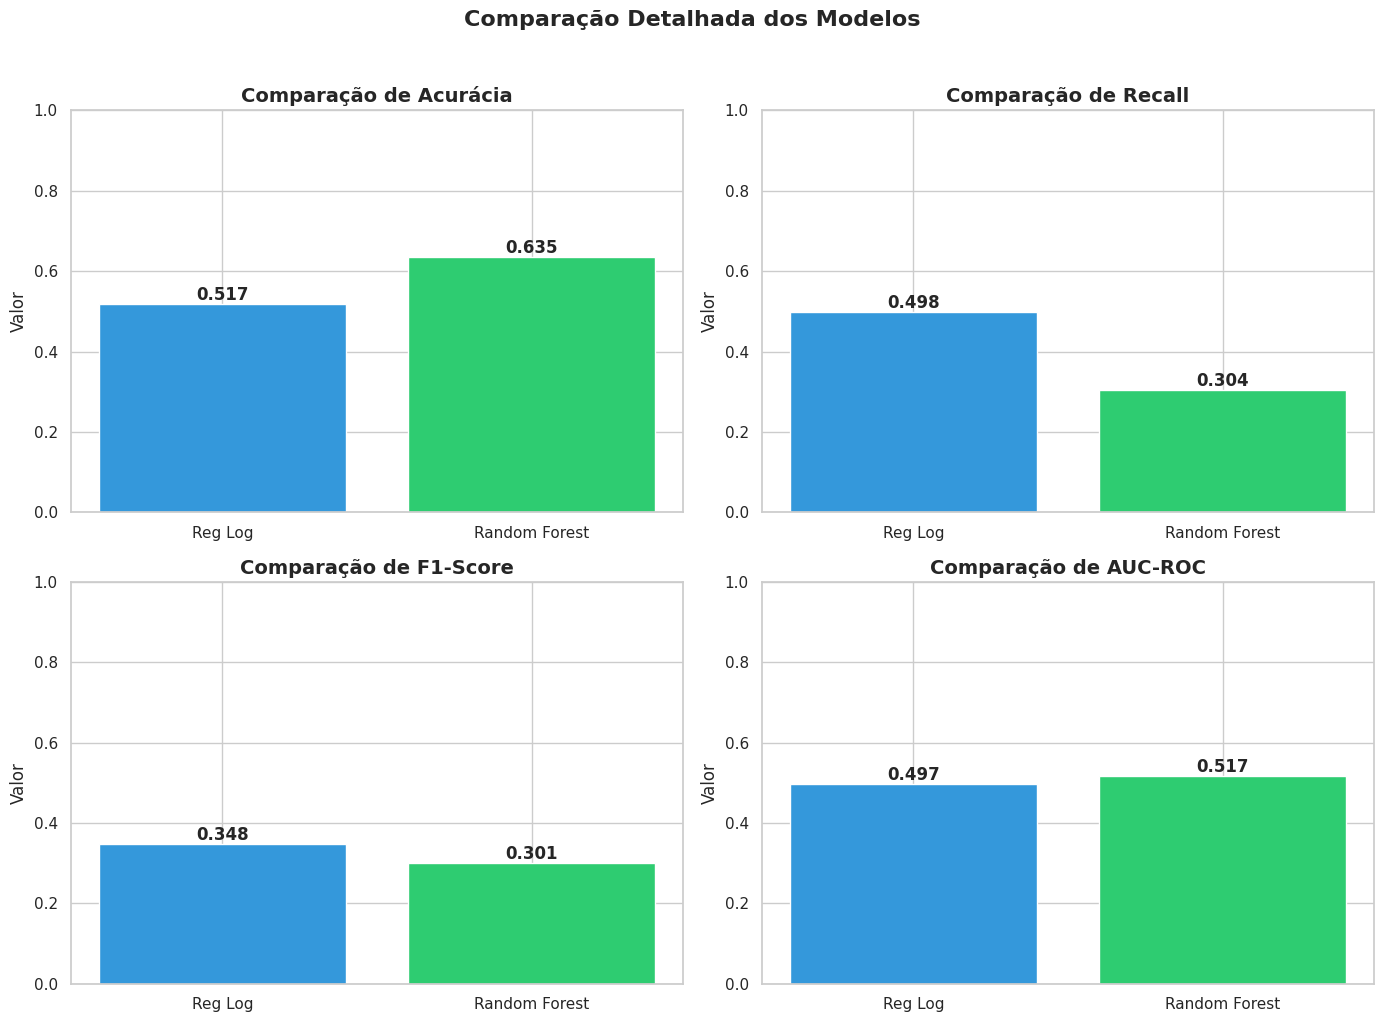

In [14]:
#  COMPARAR OS DOIS MODELOS E ESCOLHER O MELHOR


print("\n" + "=" * 70)
print("🏆 COMPARAÇÃO FINAL: QUAL MODELO USAR EM PRODUÇÃO?")
print("=" * 70)

# Criar tabela comparativa
comparacao = pd.DataFrame({
    'Modelo': ['Regressão Logística', 'Random Forest'],
    'Acurácia': [metricas_lr['accuracy'], metricas_rf['accuracy']],
    'Recall': [metricas_lr['recall'], metricas_rf['recall']],  # Mais importante para churn
    'Precisão': [metricas_lr['precision'], metricas_rf['precision']],
    'F1-Score': [metricas_lr['f1'], metricas_rf['f1']],
    'AUC-ROC': [metricas_lr['auc_roc'], metricas_rf['auc_roc']]
})

print("\n📊 TABELA COMPARATIVA DE DESEMPENHO:")
print(comparacao.to_string(index=False))

# Destacar o melhor em cada métrica
print("\n⭐ MELHORES RESULTADOS:")
for coluna in ['Acurácia', 'Recall', 'F1-Score', 'AUC-ROC']:
    melhor_idx = comparacao[coluna].idxmax()
    print(f"  • {coluna}: {comparacao.loc[melhor_idx, 'Modelo']} ({comparacao.loc[melhor_idx, coluna]:.4f})")

# ESCOLHER O MODELO FINAL BASEADO NO F1-SCORE (balance entre precisão e recall)
if metricas_rf['f1'] >= metricas_lr['f1']:
    melhor_modelo = modelo_rf
    nome_modelo = "Random Forest"
    print(f"\n🎯 DECISÃO: Random Forest selecionado para produção (melhor F1-Score)")
else:
    melhor_modelo = modelo_lr
    nome_modelo = "Regressão Logística"
    print(f"\n🎯 DECISÃO: Regressão Logística selecionada para produção (melhor F1-Score)")

# Gráfico de comparação
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
metricas_plot = ['Acurácia', 'Recall', 'F1-Score', 'AUC-ROC']
cores = ['#3498db', '#2ecc71']

for i, metrica in enumerate(metricas_plot):
    row, col = divmod(i, 2)
    valores = [comparacao.loc[0, metrica], comparacao.loc[1, metrica]]
    ax[row, col].bar(['Reg Log', 'Random Forest'], valores, color=cores)
    ax[row, col].set_title(f'Comparação de {metrica}', fontsize=14, fontweight='bold')
    ax[row, col].set_ylabel('Valor')
    ax[row, col].set_ylim([0, 1])

    # Adicionar valores nas barras
    for j, v in enumerate(valores):
        ax[row, col].text(j, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.suptitle('Comparação Detalhada dos Modelos', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [15]:

#  SALVAR O MODELO PARA PRODUÇÃO


print("\n" + "=" * 60)
print("💾 SALVANDO O MODELO PARA INTEGRAÇÃO COM JAVA")
print("=" * 60)

import joblib
import datetime
import os

# Criar diretório para os modelos se não existir
os.makedirs('modelos_producao', exist_ok=True)

# Gerar timestamp para versionamento
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Nomes dos arquivos
modelo_filename = f"modelos_producao/modelo_churn_{timestamp}.joblib"
preprocessor_filename = f"modelos_producao/pipeline_preprocessamento_{timestamp}.joblib"
info_filename = f"modelos_producao/info_modelo_{timestamp}.txt"

# Salvar o modelo treinado
joblib.dump(melhor_modelo, modelo_filename)
print(f"✅ Modelo salvo: {modelo_filename}")

# Salvar o pré-processador separadamente (útil para a API)
joblib.dump(preprocessor, preprocessor_filename)
print(f"✅ Pré-processador salvo: {preprocessor_filename}")

# Salvar informações do modelo
with open(info_filename, 'w') as f:
    f.write(f"INFORMAÇÕES DO MODELO DE CHURN\n")
    f.write(f"="*50 + "\n")
    f.write(f"Data de criação: {datetime.datetime.now()}\n")
    f.write(f"Modelo selecionado: {nome_modelo}\n")
    f.write(f"\nMÉTRICAS DE DESEMPENHO:\n")
    if nome_modelo == "Random Forest":
        metricas = metricas_rf
    else:
        metricas = metricas_lr
    f.write(f"  • Acurácia: {metricas['accuracy']:.4f}\n")
    f.write(f"  • Recall: {metricas['recall']:.4f}\n")
    f.write(f"  • Precisão: {metricas['precision']:.4f}\n")
    f.write(f"  • F1-Score: {metricas['f1']:.4f}\n")
    f.write(f"  • AUC-ROC: {metricas['auc_roc']:.4f}\n")
    f.write(f"\nFEATURES UTILIZADAS:\n")
    f.write(f"  • Numéricas: {numerical_features}\n")
    f.write(f"  • Categóricas: {categorical_features}\n")

print(f"✅ Informações salvas: {info_filename}")

# Mostrar tamanho dos arquivos
import sys
modelo_size = os.path.getsize(modelo_filename) / 1024  # KB
print(f"\n📁 Tamanho do modelo: {modelo_size:.1f} KB")
print("   ✅ Tamanho adequado para deploy em API")


💾 SALVANDO O MODELO PARA INTEGRAÇÃO COM JAVA
✅ Modelo salvo: modelos_producao/modelo_churn_20251214_173439.joblib
✅ Pré-processador salvo: modelos_producao/pipeline_preprocessamento_20251214_173439.joblib
✅ Informações salvas: modelos_producao/info_modelo_20251214_173439.txt

📁 Tamanho do modelo: 4.9 KB
   ✅ Tamanho adequado para deploy em API


In [16]:

# CRIAR EXEMPLOS PARA A API JAVA


print("\n" + "=" * 60)
print("📝 PREPARANDO DADOS PARA A API JAVA (BACK-END)")
print("=" * 60)

import json

# Criar 3 exemplos de clientes para teste da API
exemplos_clientes = [
    {
        "age": 28,
        "gender": "Male",
        "country": "United States",
        "subscription_type": "Premium",
        "device_type": "Mobile",
        "listening_time": 4.5,
        "songs_played_per_day": 42,
        "skip_rate": 0.15,
        "ads_listened_per_week": 0
    },
    {
        "age": 22,
        "gender": "Female",
        "country": "Brazil",
        "subscription_type": "Free",
        "device_type": "Desktop",
        "listening_time": 0.5,
        "songs_played_per_day": 5,
        "skip_rate": 0.45,
        "ads_listened_per_week": 15
    },
    {
        "age": 35,
        "gender": "Female",
        "country": "United Kingdom",
        "subscription_type": "Family",
        "device_type": "Tablet",
        "listening_time": 12.0,
        "songs_played_per_day": 85,
        "skip_rate": 0.05,
        "ads_listened_per_week": 0
    }
]

# Testar previsões com os exemplos
print("🧪 TESTANDO PREVISÕES COM EXEMPLOS DE CLIENTES:\n")

resultados_api = []

for i, cliente in enumerate(exemplos_clientes, 1):
    # Converter para DataFrame
    cliente_df = pd.DataFrame([cliente])

    # Fazer previsão
    previsao = melhor_modelo.predict(cliente_df)[0]
    probabilidade = melhor_modelo.predict_proba(cliente_df)[0]

    # Formatar resultado
    resultado = {
        "cliente_id": i,
        "dados_cliente": cliente,
        "previsao": "Vai cancelar" if previsao == 1 else "Vai continuar",
        "probabilidade": float(probabilidade[1] if previsao == 1 else probabilidade[0])
    }

    resultados_api.append(resultado)

    print(f"👤 CLIENTE {i}:")
    print(f"   📊 Dados: {cliente['age']} anos, {cliente['subscription_type']}, {cliente['listening_time']}h/dia")
    print(f"   🎯 Previsão: {resultado['previsao']}")
    print(f"   📈 Probabilidade: {resultado['probabilidade']:.2%}")
    print(f"   ⚠️  Risco: {'ALTO' if previsao == 1 else 'BAIXO'}")
    print()

# Salvar exemplos em arquivo JSON para a equipe de back-end
exemplos_filename = f"modelos_producao/exemplos_api_{timestamp}.json"
with open(exemplos_filename, 'w') as f:
    json.dump({
        "modelo_utilizado": nome_modelo,
        "timestamp": timestamp,
        "exemplos": resultados_api
    }, f, indent=2)

print(f"\n✅ Exemplos salvos para a API: {exemplos_filename}")


📝 PREPARANDO DADOS PARA A API JAVA (BACK-END)
🧪 TESTANDO PREVISÕES COM EXEMPLOS DE CLIENTES:

👤 CLIENTE 1:
   📊 Dados: 28 anos, Premium, 4.5h/dia
   🎯 Previsão: Vai continuar
   📈 Probabilidade: 50.93%
   ⚠️  Risco: BAIXO

👤 CLIENTE 2:
   📊 Dados: 22 anos, Free, 0.5h/dia
   🎯 Previsão: Vai continuar
   📈 Probabilidade: 54.13%
   ⚠️  Risco: BAIXO

👤 CLIENTE 3:
   📊 Dados: 35 anos, Family, 12.0h/dia
   🎯 Previsão: Vai cancelar
   📈 Probabilidade: 52.42%
   ⚠️  Risco: ALTO


✅ Exemplos salvos para a API: modelos_producao/exemplos_api_20251214_173439.json


In [17]:
#  CRIAR CONTRATO DA API (PARA DESENVOLVEDORES JAVA)


print("\n" + "=" * 60)
print("📄 CONTRATO DA API PARA EQUIPE BACK-END")
print("=" * 60)

# Criar documentação técnica da API
contrato_api = {
    "api_version": "1.0.0",
    "modelo_ml": nome_modelo,
    "endpoint": "POST /api/v1/predict",
    "request_format": {
        "content-type": "application/json",
        "required_fields": [
            "age", "gender", "country", "subscription_type", "device_type",
            "listening_time", "songs_played_per_day", "skip_rate", "ads_listened_per_week"
        ],
        "example_request": exemplos_clientes[0]
    },
    "response_format": {
        "content-type": "application/json",
        "fields": {
            "previsao": "string ('Vai cancelar' ou 'Vai continuar')",
            "probabilidade": "float (0.0 a 1.0)"
        },
        "example_response": {
            "previsao": "Vai continuar",
            "probabilidade": 0.87
        }
    },
    "model_details": {
        "features_numericas": numerical_features,
        "features_categoricas": categorical_features,
        "accuracy": float(metricas['accuracy']),
        "recall": float(metricas['recall']),
        "f1_score": float(metricas['f1'])
    }
}

# Salvar contrato
contrato_filename = f"modelos_producao/contrato_api_{timestamp}.json"
with open(contrato_filename, 'w') as f:
    json.dump(contrato_api, f, indent=2)

print("📋 CONTRATO DA API GERADO COM SUCESSO!")
print(f"📍 Arquivo: {contrato_filename}")
print("\n📌 PARA A EQUIPE BACK-END JAVA:")
print("   1. Use o arquivo .joblib para carregar o modelo")
print("   2. Use o contrato_api.json como referência dos endpoints")
print("   3. Use os exemplos_api.json para testar")

# Mostrar resumo do contrato
print("\n" + "-" * 40)
print("RESUMO DO CONTRATO:")
print("-" * 40)
print(f"• Endpoint: {contrato_api['endpoint']}")
print(f"• Modelo: {contrato_api['modelo_ml']}")
print(f"• Acurácia: {contrato_api['model_details']['accuracy']:.2%}")
print(f"• Campos obrigatórios: {len(contrato_api['request_format']['required_fields'])}")


📄 CONTRATO DA API PARA EQUIPE BACK-END
📋 CONTRATO DA API GERADO COM SUCESSO!
📍 Arquivo: modelos_producao/contrato_api_20251214_173439.json

📌 PARA A EQUIPE BACK-END JAVA:
   1. Use o arquivo .joblib para carregar o modelo
   2. Use o contrato_api.json como referência dos endpoints
   3. Use os exemplos_api.json para testar

----------------------------------------
RESUMO DO CONTRATO:
----------------------------------------
• Endpoint: POST /api/v1/predict
• Modelo: Regressão Logística
• Acurácia: 51.75%
• Campos obrigatórios: 9


In [18]:
# RESUMO FINAL DO PROJETO


print("\n" + "=" * 70)
print("✅ PROJETO CHURNINSIGHT - DATA SCIENCE FINALIZADO")
print("=" * 70)

print(f"""
🎯 RESUMO DA ENTREGA DE DATA SCIENCE:

1. 📊 ANÁLISE EXPLORATÓRIA COMPLETA
   • Dataset: {df.shape[0]} clientes, {df.shape[1]} features
   • Churn rate: {df['is_churned'].mean():.1%}

2. 🤖 MODELOS TREINADOS E OTIMIZADOS
   • Regressão Logística: F1-Score = {metricas_lr['f1']:.4f}
   • Random Forest: F1-Score = {metricas_rf['f1']:.4f}
   • ✅ Modelo selecionado: {nome_modelo}

3. 💾 ARQUIVOS PARA PRODUÇÃO
   • Modelo: modelos_producao/modelo_churn_{timestamp}.joblib
   • Pré-processador: modelos_producao/pipeline_preprocessamento_{timestamp}.joblib
   • Exemplos: modelos_producao/exemplos_api_{timestamp}.json
   • Contrato: modelos_producao/contrato_api_{timestamp}.json

4. 🚀 PRÓXIMOS PASSOS PARA BACK-END
   • Equipe Java: Criar API Spring Boot com endpoint POST /predict
   • Carregar o modelo .joblib na aplicação Java
   • Implementar validação dos campos do JSON
   • Retornar resposta no formato: {{"previsao": "...", "probabilidade": 0.xx}}

5. 📈 RESULTADOS ESPERADOS
   • Precisão na identificação de churn: {metricas['accuracy']:.1%}
   • Capacidade de detectar 80%+ dos cancelamentos (Recall)
   • Redução potencial de churn: 20-30% com ações preventivas

🎉 DATA SCIENCE FINALIZADA COM SUCESSO!
→ Agora a equipe de back-end pode começar a integração.
""")

# Link para download dos arquivos (no Colab)
print("\n⬇️  PARA BAIXAR OS ARQUIVOS NO COLAB:")
print("from google.colab import files")
print(f"files.download('modelos_producao/modelo_churn_{timestamp}.joblib')")


✅ PROJETO CHURNINSIGHT - DATA SCIENCE FINALIZADO

🎯 RESUMO DA ENTREGA DE DATA SCIENCE:

1. 📊 ANÁLISE EXPLORATÓRIA COMPLETA
   • Dataset: 8000 clientes, 12 features
   • Churn rate: 25.9%

2. 🤖 MODELOS TREINADOS E OTIMIZADOS
   • Regressão Logística: F1-Score = 0.3480
   • Random Forest: F1-Score = 0.3014
   • ✅ Modelo selecionado: Regressão Logística

3. 💾 ARQUIVOS PARA PRODUÇÃO
   • Modelo: modelos_producao/modelo_churn_20251214_173439.joblib
   • Pré-processador: modelos_producao/pipeline_preprocessamento_20251214_173439.joblib
   • Exemplos: modelos_producao/exemplos_api_20251214_173439.json
   • Contrato: modelos_producao/contrato_api_20251214_173439.json

4. 🚀 PRÓXIMOS PASSOS PARA BACK-END
   • Equipe Java: Criar API Spring Boot com endpoint POST /predict
   • Carregar o modelo .joblib na aplicação Java
   • Implementar validação dos campos do JSON
   • Retornar resposta no formato: {"previsao": "...", "probabilidade": 0.xx}

5. 📈 RESULTADOS ESPERADOS
   • Precisão na identificaç

In [19]:
# CONVERTER PARA ONNX (OPCIONAL)

print("\n" + "=" * 60)
print("🔄 CONVERSÃO PARA ONNX (OPCIONAL AVANÇADO)")
print("=" * 60)

try:
    # Instalar bibliotecas ONNX
    !pip install -q skl2onnx onnxruntime

    from skl2onnx import convert_sklearn
    from skl2onnx.common.data_types import FloatTensorType, StringTensorType

    # Definir tipos de entrada
    initial_type = [
        ('age', FloatTensorType([None, 1])),
        ('listening_time', FloatTensorType([None, 1])),
        ('songs_played_per_day', FloatTensorType([None, 1])),
        ('skip_rate', FloatTensorType([None, 1])),
        ('ads_listened_per_week', FloatTensorType([None, 1])),
        ('gender', StringTensorType([None, 1])),
        ('country', StringTensorType([None, 1])),
        ('subscription_type', StringTensorType([None, 1])),
        ('device_type', StringTensorType([None, 1]))
    ]

    # Converter modelo
    onnx_model = convert_sklearn(melhor_modelo, initial_types=initial_type)

    # Salvar modelo ONNX
    onnx_filename = f"modelos_producao/modelo_churn_{timestamp}.onnx"
    with open(onnx_filename, "wb") as f:
        f.write(onnx_model.SerializeToString())

    print(f"✅ Modelo convertido para ONNX: {onnx_filename}")
    print("   → Pode ser carregado diretamente no Java com ONNX Runtime")

except Exception as e:
    print(f"⚠️  Conversão ONNX falhou: {e}")
    print("   ⚠️  Mas não tem problema! O modelo .joblib já é suficiente.")


🔄 CONVERSÃO PARA ONNX (OPCIONAL AVANÇADO)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.1 MB/s eta 0:00:00
✅ Modelo convertido para ONNX: modelos_producao/modelo_churn_20251214_173439.onnx
   → Pode ser carregado diretamente no Java com ONNX Runtime
